<a href="https://colab.research.google.com/github/duybluemind1988/Data-science/blob/master/IGI_material_control_prediction%20v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#!pip install altair_viewer #Need to install this package

In [3]:
#!pip install jupyter altair vega #No need to install this package

In [4]:
# VERY IMPORTANT INFORMATION
print('Please input number of feature')
feature_num=5
print('Please input number of sample inspection')
sample_num=5
print('Please input position of sample value')
namefile='MMD2019'


Please input number of feature
Please input number of sample inspection
Please input position of sample value


In [5]:
import seaborn as sns; sns.set()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from plotly.offline import iplot
import pandas as pd
import re
import altair as alt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
#alt.renderers.enable('notebook')
#alt.renderers.enable('mimetype')

In [7]:
import os
os.getcwd()

'/content'

In [8]:
path='/content/drive/My Drive/Data/IGI material Membrane 2019/'
#path='/content/drive/My Drive/Data science/Sonion project/IGI material Armature/'
#path1='/content/drive/My Drive/Data/MMD 2019/'
#path2='/content/drive/My Drive/Data/MMD 2018/'

### read all excel file and sort  by day

In [9]:
import glob
#print(path)
all_files1=glob.glob(path + '*.xlsx')
all_files2=glob.glob(path + '*.xlsm')
all_file=all_files1+all_files2
#sort file in directory by reverse:
all_files = sorted(all_files, reverse = False)
print('number of files: ',len(all_files))

number of files:  29


### Initial number of feature and sample:

### add all dataframe to list of dataframe:

In [10]:
finaldf=pd.DataFrame()
for filename in all_files:
    df = pd.read_excel(filename, index_col = None, header = 0)
    #Create data frame feature values(newdf)
    newdf=pd.DataFrame()
    for i in range(feature_num+1)[1:]:
      df_feature= df['Unnamed: '+str(i)][19:(19+sample_num)] #must be = 19 + sample_num /24 la mac dinh
      df_feature=df_feature.reset_index(drop=True)
      newdf=pd.concat([newdf,df_feature],axis=1)
    #print(newdf)  

    #Date transform:
    a=df[['Unnamed: 7']][3:4] #object type - normal is [2:3]
    if a.isna().values:
      a=df[['Unnamed: 7']][2:3]
      date = a.values[0][0] #timestamp type
    else:
      date = a.values[0][0] #timestamp type
    if isinstance(date, str):
      continue
    #Create series date column (row = number of value to record, default = 5)
    date=pd.Series(date)
    datedf=pd.DataFrame()
    for i in range(sample_num):
      datedf=pd.concat([datedf,date],axis=0)

    datedf.reset_index(drop=True, inplace=True)
    newdf.reset_index(drop=True, inplace=True)
    df_combine=pd.concat([datedf,newdf],axis=1) # combine date and features

    #combine all df each filename:
    
    finaldf=pd.concat([finaldf,df_combine],axis=0)
print(finaldf.isnull().sum())
finaldf.reset_index(drop=True,inplace=True)
finaldf.sort_values(by=finaldf.columns[0])
finaldf

0             0
Unnamed: 1    0
Unnamed: 2    0
Unnamed: 3    0
Unnamed: 4    0
Unnamed: 5    0
dtype: int64


,0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5
0,2019-01-11,10.003,1.219,3.197,11.855,0.31
1,2019-01-11,10.005,1.219,3.19,11.855,0.31
2,2019-01-11,10.005,1.219,3.194,11.852,0.31
3,2019-01-11,10.002,1.218,3.198,11.855,0.311
4,2019-01-11,10.003,1.219,3.19,11.85,0.31
...,...,...,...,...,...,...
140,2019-12-31,9.991,1.218,3.199,11.85,0.313
141,2019-12-31,9.999,1.218,3.204,11.849,0.314
142,2019-12-31,10.003,1.219,3.202,11.847,0.313
143,2019-12-31,10.002,1.219,3.201,11.847,0.312


In [11]:
#finaldf.to_csv('finaldfMMD.csv')

In [12]:
finaldf.dropna(inplace=True)
finaldf  

,0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5
0,2019-01-11,10.003,1.219,3.197,11.855,0.31
1,2019-01-11,10.005,1.219,3.19,11.855,0.31
2,2019-01-11,10.005,1.219,3.194,11.852,0.31
3,2019-01-11,10.002,1.218,3.198,11.855,0.311
4,2019-01-11,10.003,1.219,3.19,11.85,0.31
...,...,...,...,...,...,...
140,2019-12-31,9.991,1.218,3.199,11.85,0.313
141,2019-12-31,9.999,1.218,3.204,11.849,0.314
142,2019-12-31,10.003,1.219,3.202,11.847,0.313
143,2019-12-31,10.002,1.219,3.201,11.847,0.312


In [13]:
finaldf.reset_index(drop=True,inplace=True)
column_name=[]
column_name.append('Datef')
for i in range(feature_num+1)[1:]:
  #print(df['Unnamed: '+str(i)][7])
  namecolumn_temp=df['Unnamed: '+str(i)][7]
  namecolumn_temp=namecolumn_temp.replace('.','')
  column_name.append(namecolumn_temp)
finaldf.columns=column_name
finaldf.sort_values(by='Datef') #sort dated , not depend on file sorting
for name in finaldf.columns[1:]:
  try:
    finaldf[name]=finaldf[name].astype(float)
  except:
    continue
finaldf[:3] 

,Datef,C-Pitch,J,I,O,Z
0,2019-01-11,10.003,1.219,3.197,11.855,0.31
1,2019-01-11,10.005,1.219,3.190,11.855,0.31
2,2019-01-11,10.005,1.219,3.194,11.852,0.31


In [14]:
finaldf.dtypes

Datef      datetime64[ns]
C-Pitch           float64
J                 float64
I                 float64
O                 float64
Z                 float64
dtype: object

In [15]:
finaldf = finaldf.select_dtypes(exclude=['object'])
finaldf.dtypes

Datef      datetime64[ns]
C-Pitch           float64
J                 float64
I                 float64
O                 float64
Z                 float64
dtype: object

### set up tolerance dict:USL,LSL,Nominal

In [16]:
#set up tolerance dict:USL,LSL,Nominal
#Tolerance set up when not drop object type column, not reflect exactly tolerance vs data analysis
tolerance={}
for column in df.columns[1:(feature_num+1)]:
    namecolumn_temp=df[column][7] #df: dataframe latest in for loop
    namecolumn_temp=namecolumn_temp.replace('.','')
    tolerance[namecolumn_temp] =[df[column][9],df[column][10],df[column][15]]
tolerance

{'C-Pitch': [10.01, 9.99, 10],
 'I': [3.21, 3.1900000000000004, 3.2],
 'J': [1.22, 1.21, 1.21],
 'O': [11.86, 11.84, 11.85],
 'Z': [0.32, 0.27999999999999997, 0.3]}

In [17]:
#Create list of dataframe, combine feature value and USL,LSL, Nominal
DFdict={}
for name in finaldf.columns[1:]:
    print('Chart: ',name)
        
    #Create series USL:
    USL = tolerance[name][0]
    USL=pd.Series(USL)
    s1=pd.DataFrame()
    for i in range(len(finaldf)):
      s1=pd.concat([s1,USL],axis=0)
    s1.rename(columns={0:'USL'},inplace=True)
    
    #Create series LSL:
    LSL = tolerance[name][1]
    LSL=pd.Series(LSL)
    s2=pd.DataFrame()
    for i in range(len(finaldf)):
      s2=pd.concat([s2,LSL],axis=0)
    s2.rename(columns={0:'LSL'},inplace=True)
    
    #Create series nominal:
    nominal = tolerance[name][2]
    nominal=pd.Series(nominal)
    s3=pd.DataFrame()
    for i in range(len(finaldf)):
      s3=pd.concat([s3,nominal],axis=0)
    s3.rename(columns={0:'Nominal'},inplace=True)
    
    #combine Date,feature, LSL,USL,nominal to finaldataframe (for each feature):
    finaldf['Datef'].reset_index(drop=True,inplace=True)
    finaldf[name].reset_index(drop=True,inplace=True)
    s1.reset_index(drop=True,inplace=True)
    s2.reset_index(drop=True,inplace=True)
    s3.reset_index(drop=True,inplace=True)
    df_temp = pd.concat([finaldf['Datef'],finaldf[name],s1,s2,s3],axis=1)  

    #Create dict of dataframe for each feature columns:
    DFdict[name]=df_temp # Include Date, name, USL, LSL, nominal each parameter(J, I, O or Z...)
    #print(DFdict[name][:3])
    

Chart:  C-Pitch
Chart:  J
Chart:  I
Chart:  O
Chart:  Z


In [18]:
print(DFdict.keys())
#df=DFdict['J']
#print(df.columns)
for name in DFdict.keys():
  print(name)
  print(DFdict[name][:3])

dict_keys(['C-Pitch', 'J', 'I', 'O', 'Z'])
C-Pitch
       Datef  C-Pitch    USL   LSL  Nominal
0 2019-01-11   10.003  10.01  9.99     10.0
1 2019-01-11   10.005  10.01  9.99     10.0
2 2019-01-11   10.005  10.01  9.99     10.0
J
       Datef      J   USL   LSL  Nominal
0 2019-01-11  1.219  1.22  1.21     1.21
1 2019-01-11  1.219  1.22  1.21     1.21
2 2019-01-11  1.219  1.22  1.21     1.21
I
       Datef      I   USL   LSL  Nominal
0 2019-01-11  3.197  3.21  3.19      3.2
1 2019-01-11  3.190  3.21  3.19      3.2
2 2019-01-11  3.194  3.21  3.19      3.2
O
       Datef       O    USL    LSL  Nominal
0 2019-01-11  11.855  11.86  11.84    11.85
1 2019-01-11  11.855  11.86  11.84    11.85
2 2019-01-11  11.852  11.86  11.84    11.85
Z
       Datef     Z   USL   LSL  Nominal
0 2019-01-11  0.31  0.32  0.28      0.3
1 2019-01-11  0.31  0.32  0.28      0.3
2 2019-01-11  0.31  0.32  0.28      0.3


In [19]:
DFdict_final={}
for name in DFdict.keys():
  df=DFdict[name].copy()
  df_group=df.groupby('Datef').mean() # mean value by Date
  df_group.reset_index(inplace=True)

  value_name=df_group.columns[1] #'C-Pitch', 'J', 'I', 'O', 'Z'
  df_group[value_name] = df_group[value_name].round(decimals=3)
  #---------------------------------------------------------------#

  # Create a selection that chooses the nearest point & selects based on x-value
  #UCL,LCL,nominal:
  sigma=3
  df_final = df_group.assign(
                UCL=df_group[value_name].mean() + df_group[value_name].std()*sigma,
                LCL=df_group[value_name].mean() - df_group[value_name].std()*sigma,
                mean=df_group[value_name].mean())
  DFdict_final[name]=df_final

In [20]:
print(DFdict_final.keys())
#df=DFdict['J']
#print(df.columns)
for name in DFdict_final.keys():
  print(name)
  print(DFdict_final[name][:3])

dict_keys(['C-Pitch', 'J', 'I', 'O', 'Z'])
C-Pitch
       Datef  C-Pitch    USL   LSL  Nominal        UCL       LCL       mean
0 2019-01-11   10.004  10.01  9.99     10.0  10.006001  9.997142  10.001571
1 2019-01-22   10.001  10.01  9.99     10.0  10.006001  9.997142  10.001571
2 2019-01-26   10.002  10.01  9.99     10.0  10.006001  9.997142  10.001571
J
       Datef      J   USL   LSL  Nominal       UCL       LCL      mean
0 2019-01-11  1.219  1.22  1.21     1.21  1.222084  1.216344  1.219214
1 2019-01-22  1.219  1.22  1.21     1.21  1.222084  1.216344  1.219214
2 2019-01-26  1.220  1.22  1.21     1.21  1.222084  1.216344  1.219214
I
       Datef      I   USL   LSL  Nominal       UCL       LCL      mean
0 2019-01-11  3.194  3.21  3.19      3.2  3.206102  3.191327  3.198714
1 2019-01-22  3.199  3.21  3.19      3.2  3.206102  3.191327  3.198714
2 2019-01-26  3.200  3.21  3.19      3.2  3.206102  3.191327  3.198714
O
       Datef       O    USL    LSL  Nominal        UCL        LCL      

### Line chart plotly

In [21]:
i=1
#Layout
fig = make_subplots(
    rows=len(DFdict_final), cols=1,
    #shared_xaxes=True,
    #vertical_spacing=0.03,
    #column_widths=[0.8, 0.2],
    #subplot_titles=("Line plot "+name)
)
for name in DFdict_final.keys(): #also group
  df=DFdict_final[name].copy()
  df=df.sort_values(by=['Datef'])
  for a in df.columns[1:]:
    df[a] = df[a].round(decimals=3)

  #Control chart 1 
  fig.append_trace(go.Scatter(
                          x=df['Datef'], y=df[name],
                          mode='lines+markers',
                          name='mean ' + name,line=dict( color='#4280F5')
                          ),row=i, col=1
                )
  #USL, LSL
  fig.append_trace(go.Scatter(x=df['Datef'], y=df['USL'],name='USL '+name, line=dict( color='#FF5733')),row=i, col=1)
  fig.append_trace(go.Scatter(x=df['Datef'], y=df['LSL'],name='LSL '+name,line=dict( color='#FF5733')),row=i, col=1)
  fig.append_trace(go.Scatter(x=df['Datef'], y=df['Nominal'],name='Nominal '+name,line=dict( color='#FF5733')),row=i, col=1)
  # UCL, LCL
  fig.append_trace(go.Scatter(x=df['Datef'], y=df['UCL'],name='UCL '+name, line=dict( color='#33C2FF')),row=i, col=1)
  fig.append_trace(go.Scatter(x=df['Datef'], y=df['LCL'],name='LCL '+name, line=dict( color='#33C2FF')),row=i, col=1)
  fig.append_trace(go.Scatter(x=df['Datef'], y=df['mean'],name='mean '+name, line=dict( color='#33C2FF')),row=i, col=1)

  #Final layout:
  #fig.update_layout(height=400, width=1400, title_text='Line chart'+name)
  i=i+1
  
fig.update_layout(height=300*len(DFdict_final), width=1200, title_text='Line chart')
fig.show()

In [22]:
#fig.write_html('line_chart_combine_'+namefile+'.html')

### Box chart altair

In [23]:
import json
import datetime 

#Function convert datetime to json
def defaulta(obj):
      if isinstance(obj, (datetime.date, datetime.datetime)):
          return obj.isoformat()

In [24]:

#Set up width and hist for all chart
width_main=800
height_main=150
width_hist=100

list_chart1=[]
for name in DFdict.keys():
  df_box=DFdict[name].copy() #All values for each features
  df_box['Datef']=df_box['Datef'].dt.date
  value_name2=df_box.columns[1] #'C-Pitch', 'J', 'I', 'O', 'Z'
  #Convert datetime to json
  df_box['Datef']=df_box['Datef'].apply(lambda x: json.dumps(x, default = defaulta) )
  base1 = alt.Chart(df_box).properties(width=width_main,height=height_main)

  #Create box plot, USL, LSL, Nominal
  box=base1.mark_boxplot().encode(
      x=alt.X(
          'Datef:O',scale=alt.Scale(),title="",
          ),
      y=alt.Y(value_name2+':Q',scale=alt.Scale(zero=False),title="")
  ).properties(width=width_main,height=height_main)

  line_USL=base1.mark_line(color='red').encode(
      x=alt.X('Datef:O',scale=alt.Scale(zero=False)),
      y=alt.Y('USL:Q',scale=alt.Scale(zero=False)),
  )

  line_LSL=base1.mark_line(color='red').encode(
      x=alt.X('Datef:O',scale=alt.Scale(zero=False)),
      y=alt.Y('LSL:Q',scale=alt.Scale(zero=False)),
  )

  line_Nominal=base1.mark_line(color='red').encode(
      x=alt.X('Datef:O',scale=alt.Scale(zero=False)),
      y=alt.Y('Nominal:Q',scale=alt.Scale(zero=False)),
  )

  chart=box + line_USL + line_LSL + line_Nominal

  #Sub chart create (Histogram, USL, LSL, Nominal)
  record_bar= alt.Chart(df_box).mark_bar().encode(
      x='count()',
      y=alt.Y(value_name2, bin=True,title="")
  ).properties(
      height=height_main,
      width=width_hist
  )

  USL_rule = alt.Chart(df_box).mark_rule(color='red').encode(
      y=alt.Y('USL'),
      size=alt.value(1)
  )
  LSL_rule = alt.Chart(df_box).mark_rule(color='red').encode(
      y=alt.Y('LSL'),
      size=alt.value(1)
  )
  Nominal_rule = alt.Chart(df_box).mark_rule(color='red').encode(
      y=alt.Y('Nominal'),
      size=alt.value(1)
  )

  sub_chart=record_bar + USL_rule + LSL_rule + Nominal_rule
  boxchart= 'chart' + name
  boxchart=alt.hconcat(chart,sub_chart).properties(title='Box Plot ' + value_name2)
  list_chart1.append(boxchart)
  boxchart
  #altair_viewer.display(boxchart, inline=True)
#boxchart_combine.save('boxchart_combine.html')


In [25]:
path=os.getcwd()
path

'/content'

In [26]:
namefile

'MMD2019'

In [27]:
box_chart_combine=alt.vconcat(data=df_group)
for chart in list_chart1:
  box_chart_combine &= chart
#box_chart_combine.save('box_chart_combine'+namefile+'.html')
box_chart_combine

alt.VConcatChart(...)

In [28]:
#box_chart_combine.save(namefile+'.html')

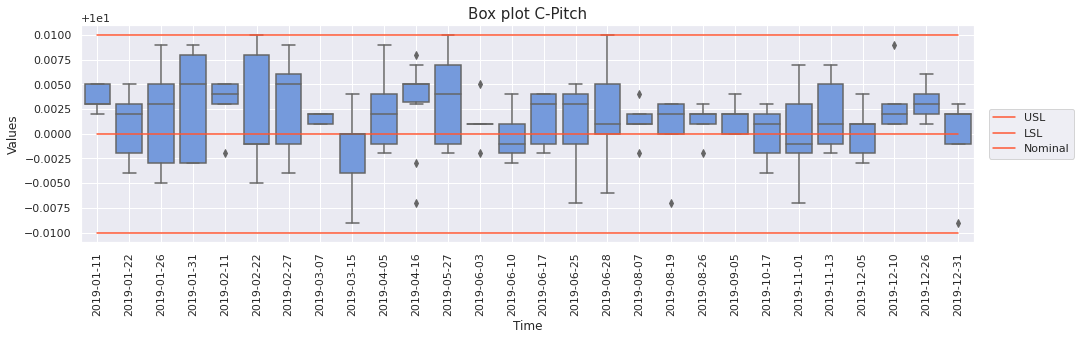

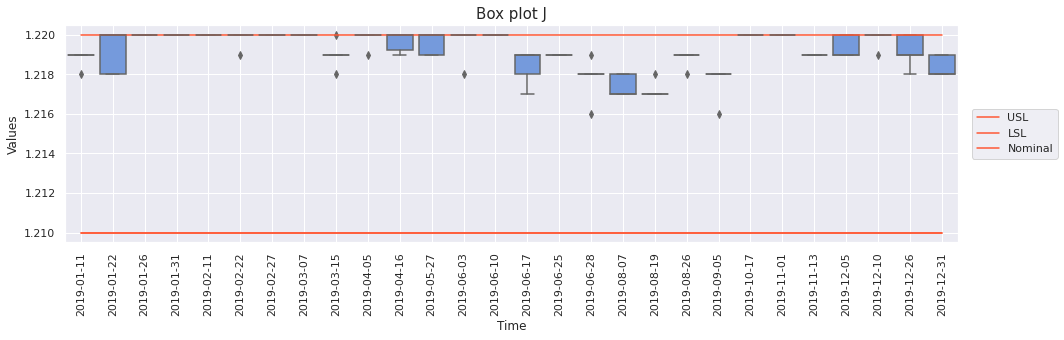

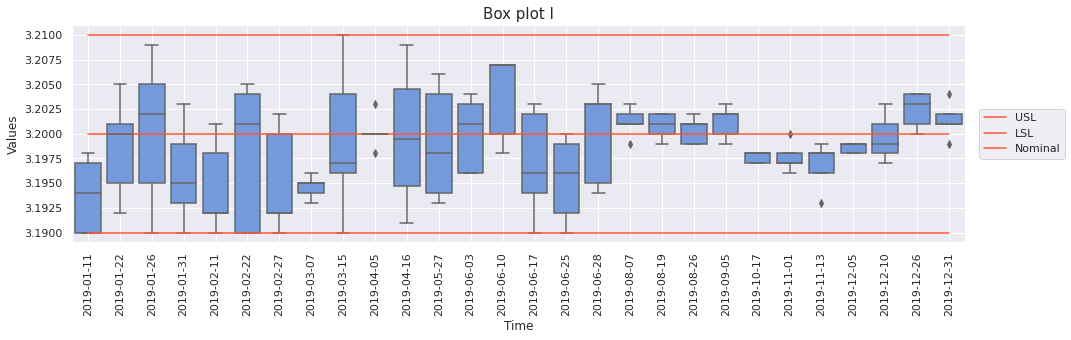

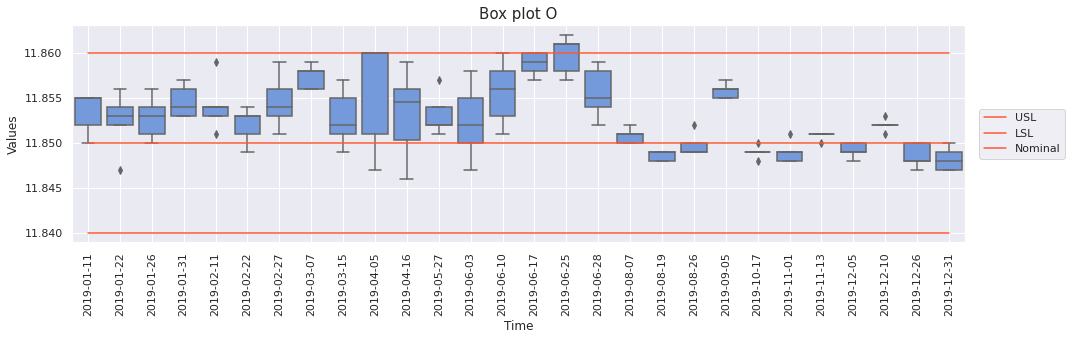

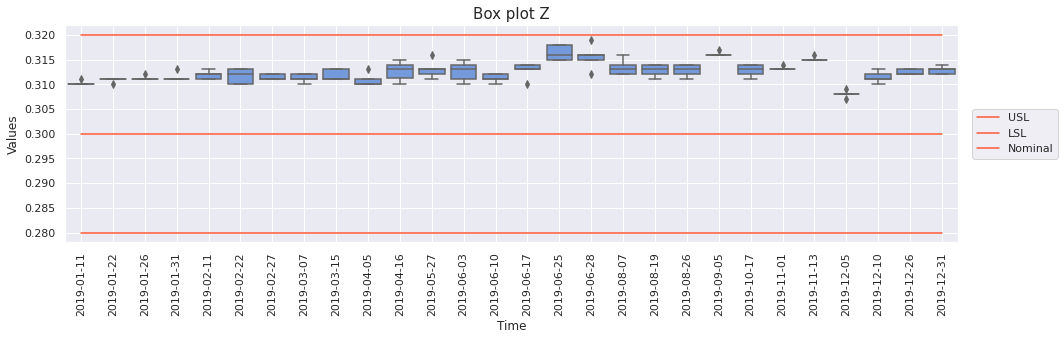

In [29]:
for name in DFdict.keys():
  df_box=DFdict[name].copy() #All values for each features
  df_box['Datef']=df_box['Datef'].dt.date
  df_box_line=df_box.groupby('Datef').mean()#Group values for line chart
  df_box_line.reset_index(inplace=True)

  fig,ax=plt.subplots(figsize=(16,4))
  sns.boxplot(x='Datef',y=name,data=df_box,ax=ax,color='cornflowerblue') 
  #df_box.boxplot(column='C-Pitch',by='Datef',ax=ax)#df_box: data with no group by date
  df_box_line.plot(y='USL',kind='line',ax=ax,color='#FF5733') #df_box_line: data with group by date
  df_box_line.plot(y='LSL',kind='line',ax=ax,color='#FF5733')
  df_box_line.plot(y='Nominal',kind='line',ax=ax,color='#FF5733')

  #plt.gca().set_xticks(df_box_line['Datef'])
  plt.gca().set_xticklabels(df_box_line['Datef'],rotation=90)
  plt.gca().set_title('Box plot '+name,fontsize=15)
  plt.gca().legend(loc ='center left',bbox_to_anchor=(1.01, 0.5))

  plt.xlabel('Time')
  plt.ylabel('Values')

In [30]:
def line_chart(DFdict_final):
    i=1
    #Layout
    fig = make_subplots(
        rows=len(DFdict_final), cols=1,
        #shared_xaxes=True,
        #vertical_spacing=0.03,
        #column_widths=[0.8, 0.2],
        subplot_titles=(list(DFdict_final.keys()))
    )
    for name in DFdict_final.keys(): #also group
      df=DFdict_final[name].copy()
      df=df.sort_values(by=['Datef'])
      for a in df.columns[1:]:
        df[a] = df[a].round(decimals=3)

      #Control chart 1 
      fig.add_trace(go.Scatter(
                              x=df['Datef'], y=df[name],
                              mode='lines+markers',
                              name='mean ' + name,line=dict( color='#4280F5')
                              ),row=i, col=1
                    )
      #USL, LSL
      fig.add_trace(go.Scatter(x=df['Datef'], y=df['USL'],name='USL '+name, line=dict( color='#FF5733')),row=i, col=1)
      fig.add_trace(go.Scatter(x=df['Datef'], y=df['LSL'],name='LSL '+name,line=dict( color='#FF5733')),row=i, col=1)
      fig.add_trace(go.Scatter(x=df['Datef'], y=df['Nominal'],name='Nominal '+name,line=dict( color='#FF5733')),row=i, col=1)
      # UCL, LCL
      fig.add_trace(go.Scatter(x=df['Datef'], y=df['UCL'],name='UCL '+name, line=dict( color='#33C2FF')),row=i, col=1)
      fig.add_trace(go.Scatter(x=df['Datef'], y=df['LCL'],name='LCL '+name, line=dict( color='#33C2FF')),row=i, col=1)
      fig.add_trace(go.Scatter(x=df['Datef'], y=df['mean'],name='mean '+name, line=dict( color='#33C2FF')),row=i, col=1)

      #Final layout:
      #fig.update_layout(height=400, width=1400, title_text='Line chart'+name)
      i=i+1

    fig.update_layout(height=300*len(DFdict_final), width=1200, title_text='Line chart')
    #fig.show()
    return fig


In [ ]:
fig_new=line_chart(DFdict_final) 
fig_new

# Forecast

## Prepare data

## FBprophet

In [ ]:
from fbprophet import Prophet

In [ ]:
#num_predict=st.number_input("Please input number of week for prediction",value=5)
#num_predict=int(num_predict)
predict_future=5 # week

In [ ]:

#@st.cache(suppress_st_warning=True)
def predict_prophet(DFdict_final):
  DF_predict_final_={} # only contail predict
  #DF_predict_all_final={} # contain predict and past value
  for name in DFdict_final.keys(): #also group
    print(name)
    df_temp_2=DFdict_final[name].copy() # gia tri mean thong thuong
    df_predict=df_temp_2.set_index(df_temp_2.columns[0]).copy()
    df_predict=df_predict.resample('1W').ffill() # gia tri mean da resample
    df_fb=df_predict.reset_index()#
    df_fb=df_fb[[df_fb.columns[0],df_fb.columns[1]]]
    df_fb.columns=['ds','y']

    # Prophet will by default fit weekly and yearly seasonalities,
    model = Prophet( #yearly_seasonality=True
                  ) #instantiate Prophet with only yearly seasonality as our data is monthly 
    model.fit(df_fb) #fit the model with your dataframe

    # predict for five months in the furure and MS - month start is the frequency
    future = model.make_future_dataframe(periods = predict_future, freq = 'W')  
    # now lets make the forecasts
    forecast = model.predict(future)
    new_forecast=forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    new_forecast['USL']=df_temp_2['USL'][0]
    new_forecast['LSL']=df_temp_2['LSL'][0]
    new_forecast['Nominal']=df_temp_2['Nominal'][0]
    new_forecast['UCL']=df_temp_2['UCL'][0]
    new_forecast['LCL']=df_temp_2['LCL'][0]
    new_forecast['mean']=df_temp_2['mean'][0]
    DF_predict_final_[name]=new_forecast 
  return DF_predict_final_
  
DF_predict_final=predict_prophet(DFdict_final)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


C-Pitch


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

J


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


I


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


O


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Z


In [ ]:
#@st.cache(suppress_st_warning=True,allow_output_mutation=True)
def line_chart_prophet(DFdict_final,DF_predict_final):

  i=1
  #Layout
  fig = make_subplots(
      rows=len(DFdict_final), cols=1,
      #shared_xaxes=True,
      #vertical_spacing=0.03,
      #column_widths=[0.8, 0.2],
      subplot_titles=(list(DFdict_final.keys()))
  )
  for name in DFdict_final.keys(): #also group
    df=DFdict_final[name].copy()
    df=df.sort_values(by=['Datef'])
    for a in df.columns[1:]:
      df[a] = df[a].round(decimals=3)

    #Control chart 1 
    fig.append_trace(go.Scatter(
                            x=df['Datef'], y=df[name],
                            mode='lines+markers',
                            name='mean ' + name,line=dict( color='#4280F5')
                            ),row=i, col=1
                  )
    #Predict:
    df_predict=DF_predict_final[name].copy()
    fig.append_trace(go.Scatter(
                        x=df_predict['ds'], y=df_predict['yhat'],
                        mode='lines+markers',
                        name='mean predict ' + name,line=dict( color='#060891')
                        ),row=i, col=1
              )

    #USL, LSL
    fig.append_trace(go.Scatter(x=df_predict['ds'], y=df_predict['USL'],name='USL '+name, line=dict( color='#FF5733')),row=i, col=1)
    fig.append_trace(go.Scatter(x=df_predict['ds'], y=df_predict['LSL'],name='LSL '+name,line=dict( color='#FF5733')),row=i, col=1)
    fig.append_trace(go.Scatter(x=df_predict['ds'], y=df_predict['Nominal'],name='Nominal '+name,line=dict( color='#FF5733')),row=i, col=1)
    # UCL, LCL
    fig.append_trace(go.Scatter(x=df_predict['ds'], y=df_predict['UCL'],name='UCL '+name, line=dict( color='#33C2FF')),row=i, col=1)
    fig.append_trace(go.Scatter(x=df_predict['ds'], y=df_predict['LCL'],name='LCL '+name, line=dict( color='#33C2FF')),row=i, col=1)
    fig.append_trace(go.Scatter(x=df_predict['ds'], y=df_predict['mean'],name='mean '+name, line=dict( color='#33C2FF')),row=i, col=1)
    # Fill between:
    fig.append_trace(go.Scatter(x=df_predict['ds'], y=df_predict['yhat_upper'],name='yhat_upper '+name, line=dict( color='#9FA0F8'),fill=None),row=i, col=1)
    fig.append_trace(go.Scatter(x=df_predict['ds'], y=df_predict['yhat_lower'],name='yhat_lower '+name, line=dict( color='#9FA0F8'), fill='tonexty'),row=i, col=1)


    #Final layout:
    #fig.update_layout(height=400, width=1400, title_text='Line chart'+name)
    i=i+1
    
  fig.update_layout(height=300*len(DFdict_final), width=1200, title_text='Line chart')
  #fig.show()
  return fig
fig_new_2=line_chart_prophet(DFdict_final,DF_predict_final)
fig_new_2.show()
#st.plotly_chart(fig_new)

In [ ]:
#------------------Save Line chart plotly-----------------------------------------#


#if st.checkbox('Save predict Line chart'):
#if st.button("Save Line chart"):
#    fig_new_2.write_html(path3+namefile+'_predict_line.html')
#    st.write('Path file: ',path3+namefile+'_predict_line.html')
#----------------------------Box chart altair----------------------------------------#

### Investigate Prophet

In [ ]:
# Python
from fbprophet import Prophet
from fbprophet.plot import plot_plotly
import plotly.offline as py
#py.init_notebook_mode()

In [ ]:
for name in DFdict_final.keys(): #also group
  print(name)
  df_temp_2=DFdict_final[name].copy() # gia tri mean thong thuong
  df_predict=df_temp_2.set_index(df_temp_2.columns[0]).copy()
  df_predict=df_predict.resample('1W').ffill() # gia tri mean da resample
  df_fb=df_predict.reset_index()#
  df_fb=df_fb[[df_fb.columns[0],df_fb.columns[1]]]
  df_fb.columns=['ds','y']
  break
model_prophet = Prophet(#seasonality_mode='additive'
                        #yearly_seasonality=True
                        )
model_prophet.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model_prophet.fit(df_fb)

# predict for five months in the furure and MS - month start is the frequency
future = model_prophet.make_future_dataframe(periods = 5, freq = 'W')  
# now lets make the forecasts
forecast = model_prophet.predict(future)
fig = plot_plotly(model_prophet, forecast)  # This returns a plotly Figure
py.iplot(fig)
#iplot(fig)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


C-Pitch


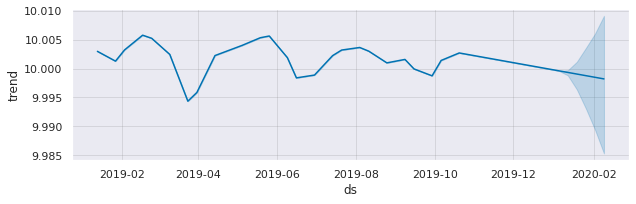

In [ ]:
model.plot_components(forecast)
plt.show()

## LSTM predict

In [86]:
# univariate mlp example
import warnings
from numpy import array
import matplotlib.pyplot as plt
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from keras.layers import RepeatVector,TimeDistributed # For LSTM
from keras.optimizers import Adam
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from keras.regularizers import l1
from keras.regularizers import l2
from keras.regularizers import l1_l2
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers import Dense
from keras.metrics import categorical_crossentropy

from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler

### Many to many (split train/test)

In [68]:
# Some functions to help out with
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real IBM Stock Price')
    plt.plot(predicted, color='blue',label='Predicted IBM Stock Price')
    plt.title('IBM Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('IBM Stock Price')
    plt.legend()
    plt.show()

In [49]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [104]:
DFdict_final.keys()

dict_keys(['C-Pitch', 'J', 'I', 'O', 'Z'])

In [109]:
for name in DFdict_final.keys(): #also group
  print(name)
  df_temp_2=DFdict_final[name].copy() # gia tri mean thong thuong
  df_predict=df_temp_2.set_index(df_temp_2.columns[0]).copy()
  df_predict=df_predict.resample('1W').ffill() # gia tri mean da resample
  df_original=df_predict.reset_index()#
  #df_lstm=df_lstm[[df_lstm.columns[0],df_lstm.columns[1]]]
  #df_fb.columns=['ds','y']
  break
df=df_original[[df_original.columns[0],df_original.columns[1]]].\
    set_index(df_original.columns[0])
df.head()

C-Pitch


In [111]:
df_original.head()

,Datef,C-Pitch,USL,LSL,Nominal,UCL,LCL,mean
0,2019-01-13,10.004,10.01,9.99,10.0,10.006001,9.997142,10.001571
1,2019-01-20,10.004,10.01,9.99,10.0,10.006001,9.997142,10.001571
2,2019-01-27,10.002,10.01,9.99,10.0,10.006001,9.997142,10.001571
3,2019-02-03,10.003,10.01,9.99,10.0,10.006001,9.997142,10.001571
4,2019-02-10,10.003,10.01,9.99,10.0,10.006001,9.997142,10.001571


In [116]:
# Define important value
split=int(len(df) * 0.80)
column=0
# choose a number of time steps
n_steps_in  = 5
n_steps_out = 1

In [118]:
training_set=df[:split][df.columns[0]] 
test_set=df[split:][df.columns[0]] 
y_test=test_set # y test
print(training_set.shape)
print(test_set.shape)

(41,)
(11,)


Prepare training set

In [ ]:
sequence=training_set
# split into samples
X_train, y_train = split_sequence(sequence, n_steps_in, n_steps_out)
# summarize the data
for i in range(len(X_train)):
	#print(X_train[i], y_train[i])

In [120]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
print(X_train.shape)
print(y_train.shape)

(36, 5, 1)
(36, 1)


Prepare test set

In [ ]:
inputs=df[df.columns[column]][len(df)-len(test_set) - n_steps_in:]
i#nputs

In [123]:
sequence=inputs
# split into samples
X_test, y_test = split_sequence(sequence, n_steps_in, n_steps_out)
# summarize the data
for i in range(len(X_test)):
	print(X_test[i], y_test[i])

[10.002 10.002 10.002 10.002 10.   ] [10.]
[10.002 10.002 10.002 10.    10.   ] [10.]
[10.002 10.002 10.    10.    10.   ] [10.]
[10.002 10.    10.    10.    10.   ] [10.002]
[10.    10.    10.    10.    10.002] [10.002]
[10.    10.    10.    10.002 10.002] [10.002]
[10.    10.    10.002 10.002 10.002] [10.]
[10.    10.002 10.002 10.002 10.   ] [10.003]
[10.002 10.002 10.002 10.    10.003] [10.003]
[10.002 10.002 10.    10.003 10.003] [10.003]
[10.002 10.    10.003 10.003 10.003] [9.999]


In [124]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
print(X_test.shape)
print(y_test.shape)

(11, 5, 1)
(11, 1)


- Mean Squared Error: mean_squared_error, MSE or mse
- Mean Absolute Error: mean_absolute_error, MAE, mae
- Mean Absolute Percentage Error: mean_absolute_percentage_error, MAPE, mape

In [136]:
from keras import backend
 
def rmse(y_true, y_pred):
	return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse',metrics=['mse','mae','mape',rmse])
model.summary()


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 5, 100)            40800     
_________________________________________________________________
lstm_13 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 101       
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________


In [137]:
# Fitting to the training set
callbacks = [EarlyStopping(monitor="val_loss", patience=3, 
                           mode='min',restore_best_weights=True),
            #ModelCheckpoint(filepath="best_model.h5",monitor="val_loss",
             #               save_best_only=True)
            ]

history=model.fit(X_train,y_train,validation_split=0.2,epochs=100,verbose=0)

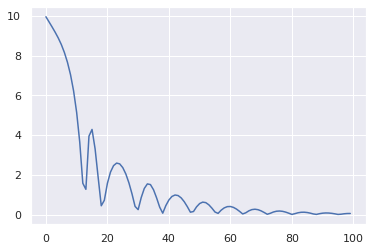

In [138]:
plt.plot(history.history['rmse'])

In [139]:
y_train_pred=model.predict(X_train)
y_test_pred=model.predict(X_test)
print('train rmse:', np.sqrt(mean_squared_error(y_train, y_train_pred)))
print('test rmse:', np.sqrt(mean_squared_error(y_test, y_test_pred)))
print('train mae:', np.sqrt(mean_absolute_error(y_train, y_train_pred)))
print('test mae:', np.sqrt(mean_absolute_error(y_test, y_test_pred)))

train rmse: 0.04755365534096896
test rmse: 0.04669799588684021
train mae: 0.21790364583333285
test mae: 0.2159941710253949


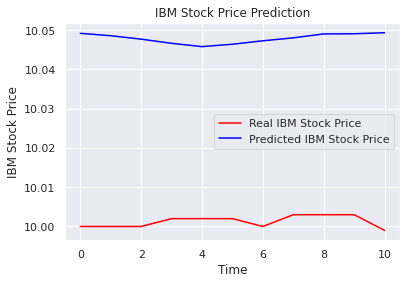

In [140]:
plt.plot(y_test, color='red',label='Real IBM Stock Price')
plt.plot(y_test_pred, color='blue',label='Predicted IBM Stock Price')
plt.title('IBM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('IBM Stock Price')
plt.legend()
plt.show()

In [141]:
df_original.head()

,Datef,C-Pitch,USL,LSL,Nominal,UCL,LCL,mean
0,2019-01-13,10.004,10.01,9.99,10.0,10.006001,9.997142,10.001571
1,2019-01-20,10.004,10.01,9.99,10.0,10.006001,9.997142,10.001571
2,2019-01-27,10.002,10.01,9.99,10.0,10.006001,9.997142,10.001571
3,2019-02-03,10.003,10.01,9.99,10.0,10.006001,9.997142,10.001571
4,2019-02-10,10.003,10.01,9.99,10.0,10.006001,9.997142,10.001571


## SARIMA

In [142]:
import itertools    
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX

warnings.filterwarnings("ignore")

def arima_grid_search(dataframe, s):
    df=dataframe
    p = d = q = range(2)
    param_combinations = list(itertools.product(p, d, q))

    lowest_aic, pdq, pdqs = None, None, None

    total_iterations = 0
    for order in param_combinations:    
        for (p, q, d) in param_combinations:
            seasonal_order = (p, q, d, s)
            total_iterations += 1
            try:
                model = SARIMAX(df, order=order, 
                    seasonal_order=seasonal_order, 
                    enforce_stationarity=False,
                    enforce_invertibility=False,
                    disp=False
                )
                model_result = model.fit(maxiter=200, disp=False)

                if not lowest_aic or model_result.aic < lowest_aic:
                    lowest_aic = model_result.aic
                    pdq, pdqs = order, seasonal_order

            except Exception as ex:
                continue

    return lowest_aic, pdq, pdqs 

In [144]:
for name in DFdict_final.keys(): #also group
  print(name)
  df_temp_2=DFdict_final[name].copy() # gia tri mean thong thuong
  df_predict=df_temp_2.set_index(df_temp_2.columns[0]).copy()
  df_predict=df_predict.resample('1W').ffill() # gia tri mean da resample
  df_original=df_predict.reset_index()#
  #df_lstm=df_lstm[[df_lstm.columns[0],df_lstm.columns[1]]]
  #df_fb.columns=['ds','y']
  break
df=df_original[[df_original.columns[0],df_original.columns[1]]].\
    set_index(df_original.columns[0])
df.head()

C-Pitch


,C-Pitch
Datef,
2019-01-13,10.004
2019-01-20,10.004
2019-01-27,10.002
2019-02-03,10.003
2019-02-10,10.003


In [ ]:
df_sarima=df[df.columns[0]].copy()
df_sarima

In [146]:
lowest_aic, order, seasonal_order = arima_grid_search(df_sarima, 12)
print('ARIMA{}x{}'.format(order, seasonal_order))
print('Lowest AIC: %.3f'%lowest_aic)

ARIMA(1, 0, 0)x(0, 0, 0, 12)
Lowest AIC: -523.331


In [147]:
model = SARIMAX(
    df_sarima,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False,
    disp=False
)

model_results = model.fit(maxiter=200, disp=False)

In [148]:
print(model_results.summary())

                           Statespace Model Results                           
Dep. Variable:                C-Pitch   No. Observations:                   52
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 263.666
Date:                Tue, 28 Jul 2020   AIC                           -523.331
Time:                        13:24:44   BIC                           -519.467
Sample:                    01-13-2019   HQIC                          -521.855
                         - 01-05-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000   1.95e-05   5.13e+04      0.000       1.000       1.000
sigma2      1.892e-06   2.54e-07      7.461      0.000     1.4e-06    2.39e-06
Ljung-Box (Q):                       53.29   Jarque-

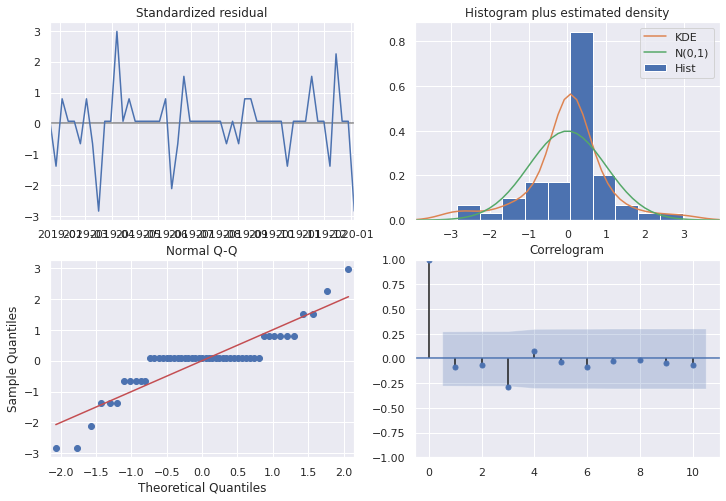

In [149]:
model_results.plot_diagnostics(figsize=(12, 8));

In [150]:
model_results.resid.describe()

count    52.000000
mean      0.192385
std       1.387306
min      -0.003902
25%       0.000098
50%       0.000098
75%       0.000098
max      10.004000
dtype: float64

In [151]:
n = len(df_sarima.index)
n

52

In [159]:
num_predict=5

In [161]:
prediction = model_results.get_prediction(
    start=n-num_predict, 
    end=n+num_predict
)
prediction_ci = prediction.conf_int()

In [162]:
prediction_ci.head()

,lower C-Pitch,upper C-Pitch
2019-12-08,9.999206,10.004598
2019-12-15,9.997206,10.002598
2019-12-22,10.000206,10.005598
2019-12-29,10.000206,10.005598
2020-01-05,10.000206,10.005598


In [163]:
df_sarima.head()

Datef
2019-01-13    10.004
2019-01-20    10.004
2019-01-27    10.002
2019-02-03    10.003
2019-02-10    10.003
Name: C-Pitch, dtype: float64

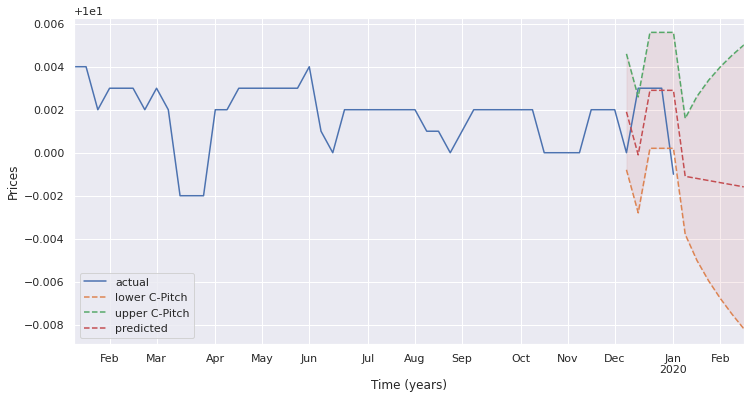

In [164]:
plt.figure(figsize=(12, 6))

ax = df_sarima.plot(label='actual')

prediction_ci.plot(
    ax=ax, style=['--', '--'],
    label='predicted/forecasted')

prediction.predicted_mean.plot(
    ax=ax, style=['--'],
    label='predicted')

ci_index = prediction_ci.index
lower_ci = prediction_ci.iloc[:, 0]
upper_ci = prediction_ci.iloc[:, 1]

ax.fill_between(ci_index, lower_ci, upper_ci,
    color='r', alpha=.1)

ax.set_xlabel('Time (years)')
ax.set_ylabel('Prices')

plt.legend()
plt.show()

## ARIMA

In [165]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
import scipy.stats as scs

In [166]:
for name in DFdict_final.keys(): #also group
  print(name)
  df_temp_2=DFdict_final[name].copy() # gia tri mean thong thuong
  df_predict=df_temp_2.set_index(df_temp_2.columns[0]).copy()
  df_predict=df_predict.resample('1W').ffill() # gia tri mean da resample
  df_original=df_predict.reset_index()#
  #df_lstm=df_lstm[[df_lstm.columns[0],df_lstm.columns[1]]]
  #df_fb.columns=['ds','y']
  break
df=df_original[[df_original.columns[0],df_original.columns[1]]].\
    set_index(df_original.columns[0])
df.head()

C-Pitch


,C-Pitch
Datef,
2019-01-13,10.004
2019-01-20,10.004
2019-01-27,10.002
2019-02-03,10.003
2019-02-10,10.003


By setting the parameters of the ARIMA model, we can obtain some
special cases:
- ARIMA (0,0,0): White noise
- ARIMA (0,1,0) without constant: Random walk
- ARIMA (p,0,q): ARMA(p, q)
- ARIMA (p, 0, 0): AR(p) model
- ARIMA (0, 0, q): MA(q) model
- ARIMA (0,1,2): Damped Holt's model
- ARIMA (0,1,1) without constant: SES model
- ARIMA (0,2,2): Holt's linear method with additive errors